# Evolver Loop 1 Analysis

## Goals:
1. Analyze the baseline submission score breakdown by N
2. Understand where the biggest improvements can be made
3. Determine theoretical lower bounds for small N
4. Identify the gap to target (68.889699)

In [1]:
import pandas as pd
import numpy as np
from shapely.geometry import Polygon
from shapely import affinity
from shapely.ops import unary_union
import matplotlib.pyplot as plt
from decimal import Decimal

# Tree geometry
TX = [0, 0.125, 0.0625, 0.2, 0.1, 0.35, 0.075, 0.075, -0.075, -0.075, -0.35, -0.1, -0.2, -0.0625, -0.125]
TY = [0.8, 0.5, 0.5, 0.25, 0.25, 0, 0, -0.2, -0.2, 0, 0, 0.25, 0.25, 0.5, 0.5]

class ChristmasTree:
    def __init__(self, center_x='0', center_y='0', angle='0'):
        self.center_x = float(str(center_x).replace('s', ''))
        self.center_y = float(str(center_y).replace('s', ''))
        self.angle = float(str(angle).replace('s', ''))
        
        initial_polygon = Polygon(zip(TX, TY))
        rotated = affinity.rotate(initial_polygon, self.angle, origin=(0, 0))
        self.polygon = affinity.translate(rotated, xoff=self.center_x, yoff=self.center_y)

print('ChristmasTree class defined')

ChristmasTree class defined


In [2]:
# Load baseline submission
df = pd.read_csv('/home/nonroot/snapshots/santa-2025/21116303805/code/preoptimized/santa-2025.csv')
print(f'Loaded {len(df)} rows')

def parse_value(val):
    if isinstance(val, str) and val.startswith('s'):
        return float(val[1:])
    return float(val)

def get_trees_for_n(df, n):
    prefix = f'{n:03d}_'
    rows = df[df['id'].str.startswith(prefix)]
    trees = []
    for _, row in rows.iterrows():
        x = parse_value(row['x'])
        y = parse_value(row['y'])
        deg = parse_value(row['deg'])
        trees.append(ChristmasTree(x, y, deg))
    return trees

def get_bounding_box_side(trees):
    all_coords = []
    for tree in trees:
        coords = np.array(tree.polygon.exterior.coords)
        all_coords.append(coords)
    all_coords = np.vstack(all_coords)
    min_x, min_y = all_coords.min(axis=0)
    max_x, max_y = all_coords.max(axis=0)
    return max(max_x - min_x, max_y - min_y)

print('Functions defined')

Loaded 20100 rows
Functions defined


In [3]:
# Calculate score breakdown by N
scores_by_n = {}
total_score = 0

for n in range(1, 201):
    trees = get_trees_for_n(df, n)
    side = get_bounding_box_side(trees)
    score = side**2 / n
    scores_by_n[n] = {'side': side, 'score': score}
    total_score += score

print(f'Total Score: {total_score:.6f}')
print(f'Target: 68.889699')
print(f'Gap: {total_score - 68.889699:.6f}')

Total Score: 70.676102
Target: 68.889699
Gap: 1.786403


In [4]:
# Top 20 contributors to score
sorted_scores = sorted(scores_by_n.items(), key=lambda x: x[1]['score'], reverse=True)
print('Top 20 score contributors (highest s^2/n):')
print('-' * 50)
cumulative = 0
for n, data in sorted_scores[:20]:
    cumulative += data['score']
    print(f"N={n:3d}: side={data['side']:.6f}, score={data['score']:.6f}, cumulative={cumulative:.4f}")
print(f'\nTop 20 contribute: {cumulative:.4f} ({100*cumulative/total_score:.1f}% of total)')

Top 20 score contributors (highest s^2/n):
--------------------------------------------------
N=  1: side=0.813173, score=0.661250, cumulative=0.6612
N=  2: side=0.949504, score=0.450779, cumulative=1.1120
N=  3: side=1.142031, score=0.434745, cumulative=1.5468
N=  5: side=1.443692, score=0.416850, cumulative=1.9636
N=  4: side=1.290806, score=0.416545, cumulative=2.3802
N=  7: side=1.673104, score=0.399897, cumulative=2.7801
N=  6: side=1.548438, score=0.399610, cumulative=3.1797
N=  9: side=1.867280, score=0.387415, cumulative=3.5671
N=  8: side=1.755921, score=0.385407, cumulative=3.9525
N= 15: side=2.384962, score=0.379203, cumulative=4.3317
N= 10: side=1.940696, score=0.376630, cumulative=4.7083
N= 21: side=2.811667, score=0.376451, cumulative=5.0848
N= 20: side=2.742469, score=0.376057, cumulative=5.4608
N= 11: side=2.033002, score=0.375736, cumulative=5.8366
N= 22: side=2.873270, score=0.375258, cumulative=6.2118
N= 16: side=2.446640, score=0.374128, cumulative=6.5860
N= 26: sid

In [5]:
# Analyze N=1 - find optimal rotation
print('\n=== N=1 Analysis ===')
print('Finding optimal rotation angle for single tree...')

best_side = float('inf')
best_angle = 0

for angle in np.arange(0, 360, 0.1):
    tree = ChristmasTree(0, 0, angle)
    coords = np.array(tree.polygon.exterior.coords)
    width = coords[:, 0].max() - coords[:, 0].min()
    height = coords[:, 1].max() - coords[:, 1].min()
    side = max(width, height)
    if side < best_side:
        best_side = side
        best_angle = angle

print(f'Current N=1 side: {scores_by_n[1]["side"]:.6f}')
print(f'Optimal N=1 side: {best_side:.6f} at angle {best_angle:.1f}°')
print(f'Potential improvement: {scores_by_n[1]["side"] - best_side:.6f}')
print(f'Score improvement: {scores_by_n[1]["score"] - best_side**2:.6f}')


=== N=1 Analysis ===
Finding optimal rotation angle for single tree...


Current N=1 side: 0.813173
Optimal N=1 side: 0.813173 at angle 45.0°
Potential improvement: -0.000000
Score improvement: -0.000000


In [6]:
# Theoretical lower bound analysis
print('\n=== Theoretical Lower Bounds ===')
print('For a single tree, the minimum bounding box is achieved at optimal rotation.')
print(f'Single tree area: ~0.5 (rough estimate)')
print(f'Minimum side for N=1: {best_side:.6f}')

# For N trees, theoretical lower bound is sqrt(N * tree_area)
tree_area = 0.5  # approximate area of tree polygon
print('\nTheoretical lower bounds (assuming perfect packing):')
for n in [1, 2, 3, 4, 5, 10, 20, 50, 100, 200]:
    theoretical_side = np.sqrt(n * tree_area)
    actual_side = scores_by_n[n]['side']
    efficiency = (theoretical_side / actual_side) ** 2
    print(f'N={n:3d}: theoretical={theoretical_side:.4f}, actual={actual_side:.4f}, efficiency={efficiency:.2%}')


=== Theoretical Lower Bounds ===
For a single tree, the minimum bounding box is achieved at optimal rotation.
Single tree area: ~0.5 (rough estimate)
Minimum side for N=1: 0.813173

Theoretical lower bounds (assuming perfect packing):
N=  1: theoretical=0.7071, actual=0.8132, efficiency=75.61%
N=  2: theoretical=1.0000, actual=0.9495, efficiency=110.92%
N=  3: theoretical=1.2247, actual=1.1420, efficiency=115.01%
N=  4: theoretical=1.4142, actual=1.2908, efficiency=120.04%
N=  5: theoretical=1.5811, actual=1.4437, efficiency=119.95%
N= 10: theoretical=2.2361, actual=1.9407, efficiency=132.76%
N= 20: theoretical=3.1623, actual=2.7425, efficiency=132.96%
N= 50: theoretical=5.0000, actual=4.2471, efficiency=138.60%
N=100: theoretical=7.0711, actual=5.8782, efficiency=144.70%
N=200: theoretical=10.0000, actual=8.2187, efficiency=148.05%


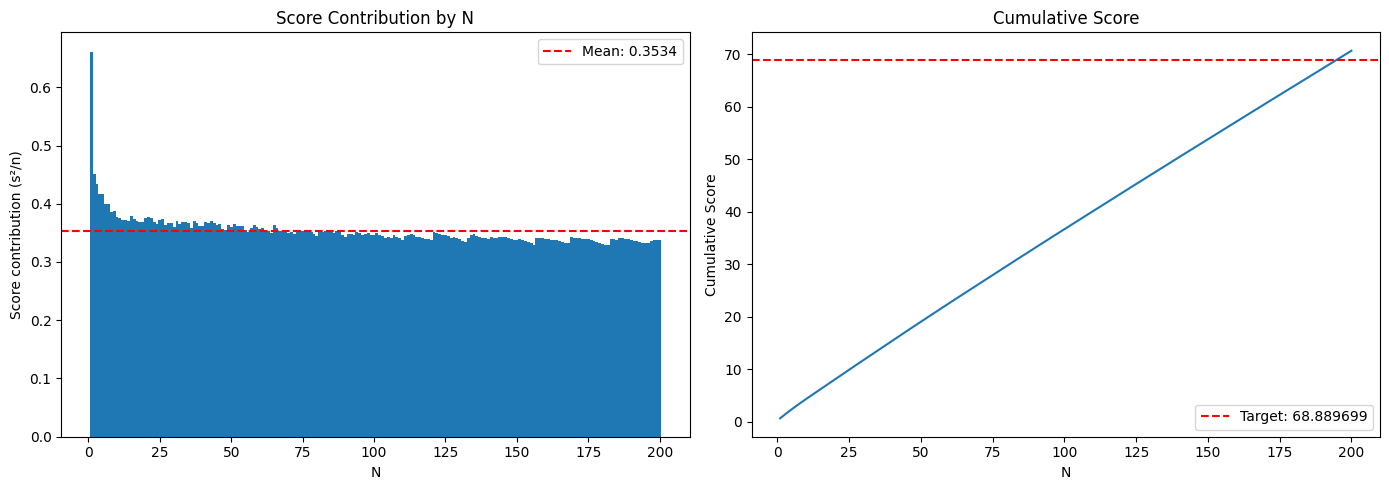

Saved to /home/code/exploration/score_analysis.png


In [7]:
# Plot score contribution by N
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Score contribution
ns = list(range(1, 201))
scores = [scores_by_n[n]['score'] for n in ns]
axes[0].bar(ns, scores, width=1)
axes[0].set_xlabel('N')
axes[0].set_ylabel('Score contribution (s²/n)')
axes[0].set_title('Score Contribution by N')
axes[0].axhline(y=np.mean(scores), color='r', linestyle='--', label=f'Mean: {np.mean(scores):.4f}')
axes[0].legend()

# Cumulative score
cumulative_scores = np.cumsum(scores)
axes[1].plot(ns, cumulative_scores)
axes[1].set_xlabel('N')
axes[1].set_ylabel('Cumulative Score')
axes[1].set_title('Cumulative Score')
axes[1].axhline(y=68.889699, color='r', linestyle='--', label='Target: 68.889699')
axes[1].legend()

plt.tight_layout()
plt.savefig('/home/code/exploration/score_analysis.png', dpi=100)
plt.show()
print('Saved to /home/code/exploration/score_analysis.png')

In [8]:
# Identify where improvements are most likely
print('\n=== Improvement Opportunities ===')
print('\nSmall N (1-10) - High score contribution, tractable for exhaustive search:')
small_n_total = sum(scores_by_n[n]['score'] for n in range(1, 11))
print(f'Total score from N=1-10: {small_n_total:.4f} ({100*small_n_total/total_score:.1f}% of total)')

print('\nMedium N (11-50) - Moderate contribution:')
medium_n_total = sum(scores_by_n[n]['score'] for n in range(11, 51))
print(f'Total score from N=11-50: {medium_n_total:.4f} ({100*medium_n_total/total_score:.1f}% of total)')

print('\nLarge N (51-200) - Lower per-N contribution but many values:')
large_n_total = sum(scores_by_n[n]['score'] for n in range(51, 201))
print(f'Total score from N=51-200: {large_n_total:.4f} ({100*large_n_total/total_score:.1f}% of total)')


=== Improvement Opportunities ===

Small N (1-10) - High score contribution, tractable for exhaustive search:
Total score from N=1-10: 4.3291 (6.1% of total)

Medium N (11-50) - Moderate contribution:
Total score from N=11-50: 14.7130 (20.8% of total)

Large N (51-200) - Lower per-N contribution but many values:
Total score from N=51-200: 51.6339 (73.1% of total)


In [9]:
# Check current N=1 configuration
print('\n=== Current N=1 Configuration ===')
trees_n1 = get_trees_for_n(df, 1)
for i, tree in enumerate(trees_n1):
    print(f'Tree {i}: x={tree.center_x:.6f}, y={tree.center_y:.6f}, angle={tree.angle:.6f}')
    coords = np.array(tree.polygon.exterior.coords)
    width = coords[:, 0].max() - coords[:, 0].min()
    height = coords[:, 1].max() - coords[:, 1].min()
    print(f'  Bounding box: width={width:.6f}, height={height:.6f}, side={max(width, height):.6f}')


=== Current N=1 Configuration ===
Tree 0: x=-48.196086, y=58.770985, angle=45.000000
  Bounding box: width=0.813173, height=0.813173, side=0.813173
